This notebook is focused on implementing many of the RL techniques described in Chapter 2 of Barto and Sutton's Reinforcement Learning text.

That chapter is generally based on solutions for the multi-armed bandit problem. Multi-armed bandit problems are ones where you have to choose between N-different options which pay out rewards, but you don't know what the rewards are ahead of time. The paid out rewards in this chapter are generally gaussian/normal distributions with different median/means, but similar covariance matrix. These distributions are also generally stable over time, although there is some acknowledgement of functions which change over time.

First, let's import common packages. Feel free to skip over this code block.

In [61]:
import random
import numpy as np
import pprint
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

The first part will be to simply set up a model class which can be used in the remaining examples. It will have N-different slots, and fixed rewards from a normal function.

In [41]:
class MultiBandit(object):
  def __init__(self, num_slots, avg=0.0, dev=1.0):
    self.num_slots = num_slots
    self._rewards = [np.random.normal(avg, dev) for _ in range(num_slots)]

  def select(self, slot):
    return np.random.normal(self._rewards[slot], 1.0)

  def update(self):
    # update will be used later
    pass

You can see the use of it below. Since the random seed is initialized, it should result in the same outcomes each time.

In [4]:
# Keeping a seed consistent
np.random.seed(1234)
NUM_SLOTS = 500
mb = MultiBandit(NUM_SLOTS)
print('select(0) -> {}'.format(mb.select(0)))
print('select(4) -> {}'.format(mb.select(4)))
print('select(0) -> {}'.format(mb.select(0)))

select(0) -> 0.994981181796292
select(4) -> 0.10092857563391056
select(0) -> 0.32269331439963045


Next, we'll create an evaluator for different Action Selector approaches. This graphs moving averages of the results from Action Selectors over counts.


In [66]:
def evaluate_selectors(bandits, selectors, num_iterations=2000):
  xs = range(num_iterations)
  all_ys = [[] for _ in range(len(selectors))]
  for _ in xs:
    for bandit in bandits:
      bandit.update()
    for i in range(len(selectors)):
      selector_function, _ = selectors[i]
      all_results = [selector_function(bandit) for bandit in bandits]
      all_ys[i].append(sum(all_results) / len(all_results))
  legend_handles = []
  for i in range(len(selectors)):
    _, selector_name = selectors[i]
    ys = all_ys[i]
    line, = plt.plot(xs, ys, linewidth=.1, label=selector_name)
    legend_handle = mlines.Line2D([], [], color=line.get_color(), label=selector_name, linewidth=2)  # Using the same color as the plot line
    legend_handles.append(legend_handle)
  plt.xlabel('N')
  plt.ylabel('Average Val')
  plt.legend(handles=legend_handles)
  plt.show()

Let's show how that works for an incredibly naive selector which only takes from the 0'th index each time.

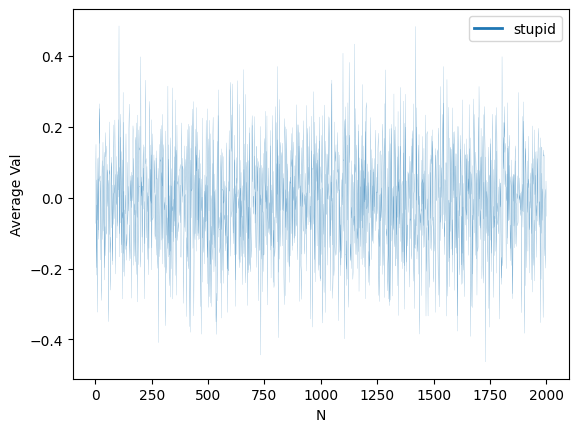

In [67]:
def stupid_selector_function(multi_bandit):
  return multi_bandit.select(0)

np.random.seed(12345678)
NUM_SLOTS = 10
evaluate_selectors([MultiBandit(NUM_SLOTS) for _ in range(50)], [(stupid_selector_function, 'stupid')])

Sections 2.3 and 2.4

The first action selector we'll use is an Epsilon Greedy Selector.

Most of the time, the Epsilon Greedy Selector will select the action that has the highest average reward so far. This is equivalent to the expected value for the action based on the samples seen so far. This is exploiting the best known action. Note that since each action returns values from a stationary gaussian, a low value sample may steer the selector to a different action in future rounds.

Some of the time - by random selection at the Epsilon rate - the Epsilon Greedy Selector will choose a random action to try. This lets the selector Explore the space of the actions and build a better model of the environment it operates in.

There is a balance to strike between no exploration - an Epsilon of 0 - and full exploration - an Epsilon of 1. In the no exploration case the Epsilon Greedy Selector may get stuck at early local maxima for a substantial period of time. In the full exploration case the Epsilon Greedy Selector will be effectively random and will not take advantage of any information that the Selector has about it's environment.

The code for the Epsilon Greedy Selector can be seen below. Note that this version uses the Incremental Implementation defined in Section 2.4.

In [47]:
class EpsilonGreedySelector(object):
  def __init__(self, epsilon):
    self._epsilon = epsilon
    self._current_estimates = {}

  def __call__(self, mb):
    estimates = self._current_estimates.get(mb, [(0.0, 0.0) for _ in range(mb.num_slots)])
    index = self._select_index(mb, estimates)
    val = mb.select(index)
    new_estimates = self._update_estimate(index, val, estimates)
    self._current_estimates[mb] = new_estimates
    return val

  def _select_index(self, mb, estimates):
    should_explore = np.random.uniform(0, 1) < self._epsilon
    if should_explore:
      return np.random.choice(range(mb.num_slots))
    else:
      def _max_element(els): return max(range(len(els)), key=lambda i: els[i][0])
      index = _max_element(estimates)
      return index

  def _update_estimate(self, index, val, estimates):
    cur_avg, cur_count = estimates[index]
    new_count = cur_count + 1
    new_avg = (cur_avg * cur_count) / new_count + val / new_count
    estimates[index] = (new_avg, new_count)
    return estimates

The following graph demonstrates reward values over time obtained by different Epsilon Greedy Selectors. The lines average over 400 different randomized Multi Bandits to play out a number of scenarios.


As shown here, the purely greedy approach - epsilon of 0 - does not explore enough and quickly gets stuck on a local maxima.

The purely random approach - epsilon of 1 - performs poorly and averages 0 as would be expected.

The other epsilon values have different rates of learning but are generally converging to the same value level which is higher than the purely greedy or purely random approaches. For example, epislon of .01 grows slowly, but catches up to .05 or .10 towards the end.

Arguably the epislon of .05 is slightly better than the .1 after a certain amount of steps. This indicates that once the learning of the stationary problem is done, it may be better to continue to exploit the best selection instead of learn more.

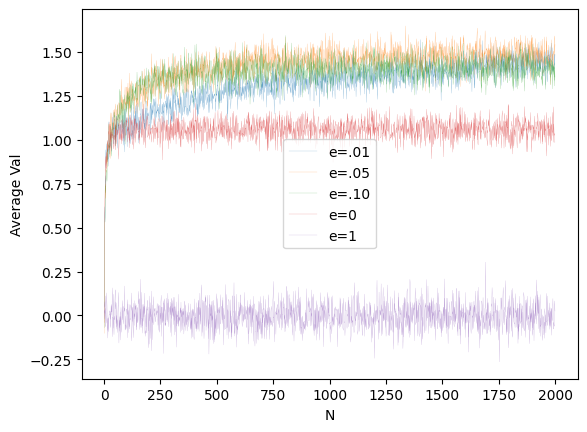

In [48]:
np.random.seed(123456)
NUM_SLOTS = 10
mbs = [MultiBandit(NUM_SLOTS) for _ in range(400)]
selectors = [(EpsilonGreedySelector(0.01), 'e=.01'),
             (EpsilonGreedySelector(0.05), 'e=.05'),
             (EpsilonGreedySelector(0.10), 'e=.10'),
             (EpsilonGreedySelector(0.0), 'e=0'),
             (EpsilonGreedySelector(1.0), 'e=1')]
evaluate_selectors(mbs, selectors, 2000)

The following graph demonstrates the impact of increasing the number of actions available to choose from. This is effectively making the state space of the environment more complex.

A few things pop out:
  - There's more spread of performance of best selectors versus worse/average
  - The learning rate is slower/longer, due to more variables to select from.
  - Similar to before, once the lower randomness (.05) learns enough about the stationary environment, it catches up and slightly outperforms a higher randomized approach.

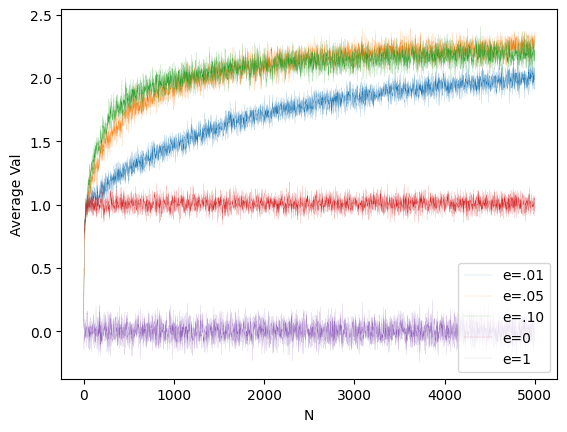

In [49]:
np.random.seed(12345678)
NUM_SLOTS = 100
mbs = [MultiBandit(NUM_SLOTS) for _ in range(400)]
selectors = [(EpsilonGreedySelector(0.01), 'e=.01'),
             (EpsilonGreedySelector(0.05), 'e=.05'),
             (EpsilonGreedySelector(0.10), 'e=.10'),
             (EpsilonGreedySelector(0.0), 'e=0'),
             (EpsilonGreedySelector(1.0), 'e=1')]
evaluate_selectors(mbs, selectors, 5000)

Section 2.5

The epsilon greedy selector maintains an average of rewards per action for all time. This approach works well for stationary problems like the multi-armed bandit so far, where the reward distribution does not change over time. However, it can be very slow to adapt to changes in non-stationary problems.

First, we'll demonstrate this on the Epislon Greedy Selectors using Moving Bandits. The Moving Bandits will have each selection perform a random walk for the mean value so they change over time.


In [54]:
class MovingBandit(object):
  def __init__(self, num_slots, avg=0.0, dev=1.0, walk_dev=.1):
    self.num_slots = num_slots
    self.walk_dev = walk_dev
    self._rewards = [0.0 for _ in range(num_slots)]

  def select(self, slot):
    return np.random.normal(self._rewards[slot], 1.0)

  def update(self):
    self._rewards = [np.random.normal(0, self.walk_dev) + self._rewards[i] for i in range(self.num_slots)]

Let's graph how the Action Values change over time to demonstrate the walk.

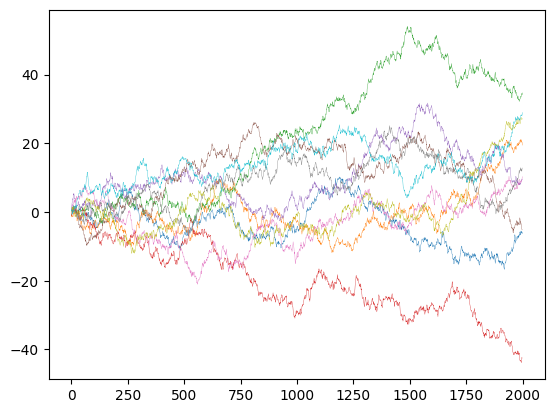

In [72]:
np.random.seed(12345678)
NUM_SLOTS = 10
bandit = MovingBandit(NUM_SLOTS, walk_dev=.5)
vals_over_time = [[] for _ in range(NUM_SLOTS)]
xs = range(2000)
for _ in xs:
  bandit.update()
  cur_rewards = bandit._rewards
  for i in range(NUM_SLOTS):
    vals_over_time[i].append(cur_rewards[i])
for i in range(NUM_SLOTS):
  plt.plot(xs, vals_over_time[i], linewidth=0.25)
plt.show()

Now let's see how the previous epsilon selectors work with a moving bandit.

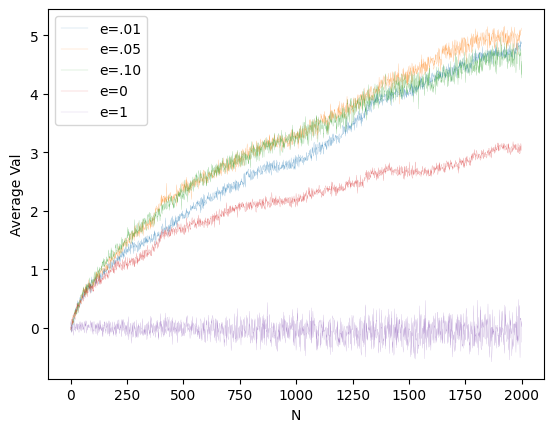

In [56]:
np.random.seed(123456)
NUM_SLOTS = 10
mbs = [MovingBandit(NUM_SLOTS) for _ in range(400)]
selectors = [(EpsilonGreedySelector(0.01), 'e=.01'),
             (EpsilonGreedySelector(0.05), 'e=.05'),
             (EpsilonGreedySelector(0.10), 'e=.10'),
             (EpsilonGreedySelector(0.0), 'e=0'),
             (EpsilonGreedySelector(1.0), 'e=1')]
evaluate_selectors(mbs, selectors, 2000)

Now we'll define a decaying selector. This is similar to the epsilon greedy selector, but will decay values over time rather than maintain permanent averages.

In [57]:
class DecayingEpsilonGreedySelector(object):
  def __init__(self, epsilon, alpha):
    self._epsilon = epsilon
    self._alpha = alpha
    self._current_estimates = {}

  def __call__(self, mb):
    estimates = self._current_estimates.get(mb, [0.0 for _ in range(mb.num_slots)])
    index = self._select_index(mb, estimates)
    val = mb.select(index)
    new_estimates = self._update_estimate(index, val, estimates)
    self._current_estimates[mb] = new_estimates
    return val

  def _select_index(self, mb, estimates):
    should_explore = np.random.uniform(0, 1) < self._epsilon
    if should_explore:
      return np.random.choice(range(mb.num_slots))
    else:
      def _max_element(els): return max(range(len(els)), key=lambda i: els[i])
      index = _max_element(estimates)
      return index

  def _update_estimate(self, index, val, estimates):
    cur_avg = estimates[index]
    new_avg = cur_avg + self._alpha * (val - cur_avg)
    estimates[index] = new_avg
    return estimates

Demonstrate how that learns and performs compared to some of the greedy estimates.

Note though that this seems to indicte that alpha of 1 performs best. That effectively means that only the most recent sample is the best approach. It's actually a bit of a surprise, but may depend on the underlying behavior being a random walk which causes it. If instead the behavior was 1 out of N samples being very noisy, but otherwise a small amount of noise it would likely not be the result we want.

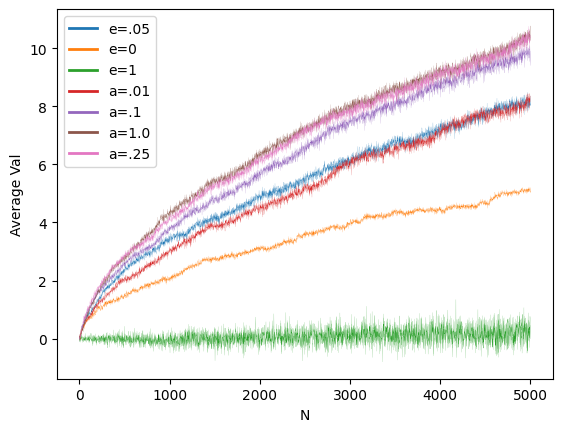

In [74]:
np.random.seed(123456)
NUM_SLOTS = 10
mbs = [MovingBandit(NUM_SLOTS, walk_dev=.1) for _ in range(400)]
selectors = [(EpsilonGreedySelector(0.05), 'e=.05'),
             (EpsilonGreedySelector(0.0), 'e=0'),
             (EpsilonGreedySelector(1.0), 'e=1'),
             (DecayingEpsilonGreedySelector(.05, .01), 'a=.01'),
             (DecayingEpsilonGreedySelector(.05, .1), 'a=.1'),
             (DecayingEpsilonGreedySelector(.05, 1.0), 'a=1.0')]
evaluate_selectors(mbs, selectors, 5000)

Let's try those approaches on stationary bandits. Here the approach of alpha 1 is problematic, likely because it focuses too heavily on recent noise and variance over tracking values.

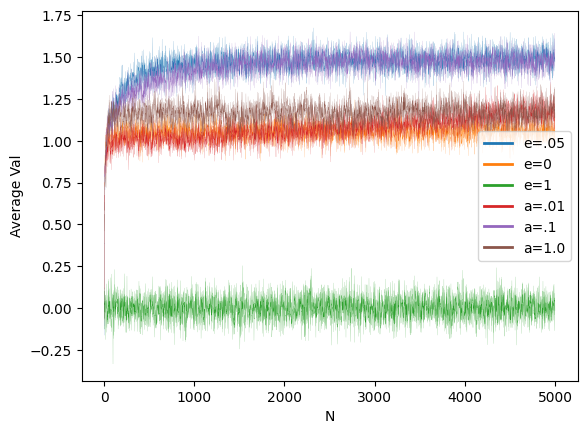

In [75]:
np.random.seed(123456)
NUM_SLOTS = 10
mbs = [MultiBandit(NUM_SLOTS) for _ in range(400)]
selectors = [(EpsilonGreedySelector(0.05), 'e=.05'),
             (EpsilonGreedySelector(0.0), 'e=0'),
             (EpsilonGreedySelector(1.0), 'e=1'),
             (DecayingEpsilonGreedySelector(.05, .01), 'a=.01'),
             (DecayingEpsilonGreedySelector(.05, .1), 'a=.1'),
             (DecayingEpsilonGreedySelector(.05, 1.0), 'a=1.0')]
evaluate_selectors(mbs, selectors, 5000)